<html>
<body>
    <center> 
        <h1><u>Assignment 1</u></h1>
        <h3> Quick intro + checking code works on your system </h3>
    </center>
</body>
</html>

### Learning Outcomes: The goal of this assignment is two-fold:

- This code-base is designed to be easily extended for different research projects. Running this notebook to the end will ensure that the code runs on your system, and that you are set-up to start playing with machine learning code.
- This notebook has one complete application: training a CNN classifier to predict the digit in MNIST Images. The code is written to familiarize you to a typical machine learning pipeline, and to the building blocks of code used to do ML. So, read on! 

## Please specify your Name, Email ID and forked repository url here:
- Name: Ling
- Email: loading@mit.edu
- Link to your forked github repository: https://github.com/asprout/Harvard_BAI

In [1]:
### General libraries useful for python ###

import os
import sys
from tqdm.notebook import tqdm
import json
import random
import pickle
import copy
from IPython.display import display
import ipywidgets as widgets

In [2]:
### Finding where you clone your repo, so that code upstream paths can be specified programmatically ####
work_dir = os.getcwd()
git_dir = '/'.join(work_dir.split('/')[:-1])
print('Your github directory is :%s'%git_dir)

Your github directory is :/rdma/vast-rdma/vast/cbmm/loading/Harvard_BAI


In [3]:
### Libraries for visualizing our results and data ###
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
### Import PyTorch and its components ###
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

#### Let's load our flexible code-base which you will build on for your research projects in future assignments.

Above we have imported modules (libraries for those familiar to programming languages other than python). These modules are of two kinds - (1) inbuilt python modules like `os`, `sys`, `random`, or (2) ones which we installed using conda (ex. `torch`).

Below we will be importing our own written code which resides in the `res` folder in your github directory. This is structured to be easily expandable for different machine learning projects. Suppose that you want to do a project on object detection. You can easily add a few files to the sub-folders within `res`, and this script will then be flexibly do detection instead of classication (which is presented here). Expanding on this codebase will be the main subject matter of Assignment 2. For now, let's continue with importing.

In [5]:
### Making helper code under the folder res available. This includes loaders, models, etc. ###
sys.path.append('%s/res/'%git_dir)
from models.models import get_model
from loader.loader import get_loader

Models are being loaded from: /rdma/vast-rdma/vast/cbmm/loading/Harvard_BAI/res/models
Loaders are being loaded from: /rdma/vast-rdma/vast/cbmm/loading/Harvard_BAI/res/loader


#### See those paths printed above?

`res/models` holds different model files. So, if you want to load ResNet architecture or a transformers architecture, they will reside there as separate files. 

Similarly, `res/loader` holds programs which are designed to load different types of data. For example, you may want to load data differently for object classification and detection. For classification each image will have only a numerical label corresponding to its category. For detection, the labels for the same image would contain bounding boxes for different objects and the type of the object in the box. 

So, to expand further you will be adding files to the folders above.

### Setting up Weights and Biases for tracking your experiments. ###

We have Weights and Biases (wandb.ai) integrated into the code for easy visualization of results and for tracking performance. `Please make an account at wandb.ai, and follow the steps to login to your account!`

In [6]:
import wandb
os.environ['WANDB_NOTEBOOK_NAME'] = "assignment_1"
wandb.login()

wandb: Currently logged in as: loading (use `wandb login --relogin` to force relogin)


True

### Specifying settings/hyperparameters for our code below ###

In [7]:
wandb_config = {}
wandb_config['batch_size'] = 64
wandb_config['base_lr'] = 1e-3
wandb_config['model_arch'] = 'SimpleCNN'
wandb_config['num_classes'] = 10
wandb_config['run_name'] = 'assignment_1'

### If you are using a CPU, please set wandb_config['use_gpu'] = 0 below. However, if you are using a GPU, leave it unchanged ####
wandb_config['use_gpu'] = torch.cuda.is_available()

wandb_config['num_epochs'] = 5
wandb_config['git_dir'] = git_dir

By changing above, different experiments can be run. For example, you can specify which model architecture to load, which dataset you will be loading, and so on.

### Data Loading ###

The most common task many of you will be doing in your projects will be running a script on a new dataset. In PyTorch this is done using data loaders, and it is extremely important to understand this works. In next assignment, you will be writing your own dataloader. For now, we only expose you to basic data loading which for the MNIST dataset for which PyTorch provides easy functions.

### Let's load MNIST. The first time you run it, the dataset gets downloaded.


Data Transforms tell PyTorch how to pre-process your data. Recall that images are stored with values between 0-255 usually. One very common pre-processing for images is to normalize to be 0 mean and 1 standard deviation. This pre-processing makes the task easier for neural networks. There are many, many kinds of normalization in deep learning, the most basic one being those imposed on the image data while loading it.

In [8]:
data_transforms = {}
data_transforms['train'] = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])

data_transforms['test'] = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])

`torchvision.datasets.MNIST` allows you to load MNIST data. In future, we will be using our own `get_loader` function from above to load custom data. Notice that data_transforms are passed as argument while loading the data below.

In [9]:
mnist_dataset = {}
mnist_dataset['train'] = torchvision.datasets.MNIST('%s/datasets' % wandb_config['git_dir'], 
                                                    train = True, download = True, 
                                                    transform = data_transforms['train'])
mnist_dataset['test'] = torchvision.datasets.MNIST('%s/datasets' % wandb_config['git_dir'], 
                                                   train = False, download = True, 
                                                   transform = data_transforms['test'])

Text(0.5, 1.0, 'Dataset example of class 5')

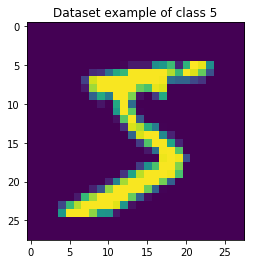

In [10]:
plt.imshow(mnist_dataset['train'][0][0][0, ...])
plt.title("Dataset example of class %d" % mnist_dataset['train'][0][1])

#### Dataset vs Dataloader

Most deep learning datasets are huge. Can be as large as million data points. We want to keep our GPUs free to store intermediate calculations for neural networks, like gradients. We would not be able to load a million samples into the GPU (or even CPU) and do forward or backward passes on the network. 

So, samples are loaded in batches, and this method of gradient descent is called mini-batch gradient descent. `torch.utils.data.DataLoader` allows you to specify a pytorch dataset, and makes it easy to loop over it in batches. So, we leverage this to create a data loader from our above loaded MNIST dataset. 

The dataset itself only contains lists of where to find the inputs and outputs i.e. paths. The data loader defines the logic on loading this information into the GPU/CPU and so it can be passed into the neural net.

In [11]:
data_loaders = {}
data_loaders['train'] = torch.utils.data.DataLoader(mnist_dataset['train'], batch_size = wandb_config['batch_size'], shuffle = True)
data_loaders['test'] = torch.utils.data.DataLoader(mnist_dataset['test'], batch_size = wandb_config['batch_size'], shuffle = False)

data_sizes = {}
data_sizes['train'] = len(mnist_dataset['train'])
data_sizes['test'] = len(mnist_dataset['test'])

### We will use the `get_model` functionality to load a CNN architecture.

In [12]:
model = get_model(wandb_config['model_arch'], wandb_config['num_classes'])

### Curious what the model architecture looks like?

`get_model` is just a function in the file `res/models/models.py`. Stop here, open this file, and see what the function does.

In [13]:
layout = widgets.Layout(width='auto', height='90px') #set width and height

button = widgets.Button(description="Read the function?\n Click me!", layout=layout)
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        print("As you can see, the function simply returns an object of the class CustomCNN, which is defined in res/models/CustomCNN.py")
        print("This is our neural network model.")
button.on_click(on_button_clicked)

Button(description='Read the function?\n Click me!', layout=Layout(height='90px', width='auto'), style=ButtonS…

Output()

#### Below we have the function which trains, tests and returns the best model weights.

In [14]:
def model_pipeline(model, criterion, optimizer, dset_loaders, dset_sizes, hyperparameters):
    with wandb.init(project="HARVARD_BAI", config=hyperparameters):
        if hyperparameters['run_name']:
            wandb.run.name = hyperparameters['run_name']
        config = wandb.config
        best_model = model
        best_acc = 0.0
        
        print(config)
        
        print(config.num_epochs)
        for epoch_num in range(config.num_epochs):
            print("Epoch %d" % (epoch_num))
            wandb.log({"Current Epoch": epoch_num})
            model = train_model(model, criterion, optimizer, dset_loaders, dset_sizes, config)
            best_acc, best_model = test_model(model, best_acc, best_model, dset_loaders, dset_sizes, config)
    
    return best_model

#### The different steps of the train model function are annotated below inside the function. Read them step by step

In [15]:
def train_model(model, criterion, optimizer, dset_loaders, dset_sizes, configs):
    print('Starting training epoch...')
    best_model = model
    best_acc = 0.0

    
    ### This tells python to track gradients. While testing weights aren't updated hence they are not stored.
    model.train() 
    running_loss = 0.0
    running_corrects = 0
    iters = 0
    
    
    ### We loop over the data loader we created above. Simply using a for loop.
    for data in tqdm(dset_loaders['train']):
        inputs, labels = data
        
        ### If you are using a gpu, then script will move the loaded data to the GPU. 
        ### If you are not using a gpu, ensure that wandb_configs['use_gpu'] is set to False above.
        if configs.use_gpu:
            inputs = inputs.float().cuda()
            labels = labels.long().cuda()
        else:
            print('WARNING: NOT USING GPU!')
            inputs = inputs.float()
            labels = labels.long()

        
        ### We set the gradients to zero, then calculate the outputs, and the loss function. 
        ### Gradients for this process are automatically calculated by PyTorch.
        
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)
        
        
        ### At this point, the program has calculated gradient of loss w.r.t. weights of our NN model.
        loss.backward()
        optimizer.step()
        
        ### optimizer.step() updated the models weights using calculated gradients.
        
        ### Let's store these and log them using wandb. They will be displayed in a nice online
        ### dashboard for you to see.
        
        iters += 1
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        wandb.log({"train_running_loss": running_loss/float(iters*len(labels.data))})
        wandb.log({"train_running_corrects": running_corrects/float(iters*len(labels.data))})

    epoch_loss = float(running_loss) / dset_sizes['train']
    epoch_acc = float(running_corrects) / float(dset_sizes['train'])
    wandb.log({"train_accuracy": epoch_acc})
    wandb.log({"train_loss": epoch_loss})
    print("Training loss: %.4f, accuracy: %.2f" % (epoch_loss, epoch_acc))
    return model



In [16]:
def test_model(model, best_acc, best_model, dset_loaders, dset_sizes, configs):
    print('Starting testing epoch...')
    model.eval() ### tells pytorch to not store gradients as we won't be updating weights while testing.

    running_corrects = 0
    iters = 0   
    for data in tqdm(dset_loaders['test']):
        inputs, labels = data
        if configs.use_gpu:
            inputs = inputs.float().cuda()
            labels = labels.long().cuda()
        else:
            print('WARNING: NOT USING GPU!')
            inputs = inputs.float()
            labels = labels.long()

        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        iters += 1
        running_corrects += torch.sum(preds == labels.data)
        wandb.log({"train_running_corrects": running_corrects/float(iters*len(labels.data))})


    epoch_acc = float(running_corrects) / float(dset_sizes['test'])

    wandb.log({"test_accuracy": epoch_acc})
    print("Test accuracy: %.2f" % (epoch_acc))
    
    ### Code is very similar to train set. One major difference, we don't update weights. 
    ### We only check the performance is best so far, if so, we save this model as the best model so far.
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model)
    wandb.log({"best_accuracy": best_acc})
    
    return best_acc, best_model
    

In [17]:
### Criterion is simply specifying what loss to use. Here we choose cross entropy loss. 
criterion = nn.CrossEntropyLoss()

### tells what optimizer to use. There are many options, we here choose Adam.
### the main difference between optimizers is that they vary in how weights are updated based on calculated gradients.
optimizer_ft = optim.Adam(model.parameters(), lr = wandb_config['base_lr'])

if wandb_config['use_gpu']:
    criterion.cuda()
    model.cuda()

In [18]:
### Creating the folder where our models will be saved.
if not os.path.isdir("%s/saved_models/"%wandb_config['git_dir']):
    os.mkdir("%s/saved_models/"%wandb_config['git_dir'])

In [19]:
### Let's run it all, and save the final best model.


best_final_model = model_pipeline(model, criterion, optimizer_ft, data_loaders, data_sizes, wandb_config)


save_path = '%s/saved_models/%s_final.pt'%(wandb_config['git_dir'], wandb_config['run_name'])
with open(save_path,'wb') as F:
    torch.save(best_final_model,F)

wandb: wandb version 0.10.17 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'num_classes': 10, 'use_gpu': True, 'batch_size': 64, 'base_lr': 0.001, 'git_dir': '/rdma/vast-rdma/vast/cbmm/loading/Harvard_BAI', 'run_name': 'assignment_1', 'num_epochs': 5, 'model_arch': 'SimpleCNN'}
5
Epoch 0
Starting training epoch...


  0%|          | 0/938 [00:00<?, ?it/s]

Training loss: 0.0052, accuracy: 0.90
Starting testing epoch...


  0%|          | 0/157 [00:00<?, ?it/s]

Test accuracy: 0.96
Epoch 1
Starting training epoch...


  0%|          | 0/938 [00:00<?, ?it/s]

Training loss: 0.0016, accuracy: 0.97
Starting testing epoch...


  0%|          | 0/157 [00:00<?, ?it/s]

Test accuracy: 0.98
Epoch 2
Starting training epoch...


  0%|          | 0/938 [00:00<?, ?it/s]

Training loss: 0.0012, accuracy: 0.98
Starting testing epoch...


  0%|          | 0/157 [00:00<?, ?it/s]

Test accuracy: 0.98
Epoch 3
Starting training epoch...


  0%|          | 0/938 [00:00<?, ?it/s]

Training loss: 0.0010, accuracy: 0.98
Starting testing epoch...


  0%|          | 0/157 [00:00<?, ?it/s]

Test accuracy: 0.98
Epoch 4
Starting training epoch...


  0%|          | 0/938 [00:00<?, ?it/s]

Training loss: 0.0009, accuracy: 0.98
Starting testing epoch...


  0%|          | 0/157 [00:00<?, ?it/s]

Test accuracy: 0.98


best_accuracy,0.9832
test_accuracy,0.9832
train_loss,0.00088
train_running_loss,0.00175
_runtime,114
train_running_corrects,3.91401
_timestamp,1612586056
_step,10189
Current Epoch,4
train_accuracy,0.98243


best_accuracy,▁▆▆▇█
test_accuracy,▁▆▆▇█
train_loss,█▂▂▁▁
train_running_corrects,▁▄▅▆▆▆▇█████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_running_loss,█▆▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Current Epoch,▁▃▅▆█
train_accuracy,▁▇▇██


### Congratulations!

You just completed your first deep learning program - image classification for MNIST. This wraps up assignment 1. In the next assignment, we will see how you can make changes to above mentioned folders/files to adapt this code-base to your own research project.

# Deliverables for Assignment 1: 

### Please run this assignment through to the end, and then make two submissions:

- Download this notebook as an HTML file. Click File ---> Download as ---> HTML. Submit this on canvas.
- Add, commit and push these changes to your github repository.

In [20]:
best_final_model

SimpleCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): AdaptiveAvgPool2d(output_size=(4, 4))
  (flatten): Flatten()
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)